# Infection Simulation


In [22]:
import popy as popy
from popy.data_fakers.soep import soep_faker
from popy.pop_maker import PopMaker

import pandas as pd
import random
import matplotlib.pyplot as plt

import datetime as dt

In [23]:
class Agent(popy.Agent):
    def __init__(self, model, *args, **kwargs):
        super().__init__(model, *args, **kwargs)

        self.infection_status = "susceptible"
        self.days_since_infection = 0
    

    def infect(self):
        if self.infection_status in ["infectious", "symptomatic"]:
            
            for agent_v in self.neighbors(self):
                if agent_v.infection_status == "susceptible":

                    contact_weight = self.contact_weight(agent_v)
                    infection_probability = self.model.p.infection_weight * contact_weight
                    
                    infection_probability = self.model.p.infection_weight * contact_weight
                    
                    if random.random() < infection_probability:
                        agent_v.infection_status = "exposed"
    

    def update_infection_status(self):
        if self.infection_status in ["exposed", "infectious", "symptomatic"]:
            self.days_since_infection += 1

            if 2 <= self.days_since_infection <= 5:
                self.infection_status = "infectious"
            
            elif 6 <= self.days_since_infection <= 10:
                self.infection_status = "symptomatic"
            
            elif self.days_since_infection >= 11:
                self.infection_status = "recovered"

In [24]:
class Home(popy.Location):
    def setup(self) -> None:
        self.weight_projection_denominator = 24

    def group(self, agent):
        return agent.hid
    
    def weight(self, agent):
        return 8


class Work(popy.Location):
    def setup(self):
        self.size = 10
        self.weight_projection_denominator = 24
    
    def join(self, agent):
        return agent.work_hours_day > 0

    def weight(self, agent):
        return agent.work_hours_day


class School(popy.Location):
    def setup(self):
        self.size = 25
        self.weight_projection_denominator = 24
    
    def join(self, agent) -> bool:
        return 6 <= agent.age <= 18

    def weight(self, agent):
        weight = 0
        
        # workday?
        if agent.model.date.weekday() < 5:
            # not ill?
            if agent.infection_status != "symptomatic" or agent.infection_status == "symptomatic" and random.random() < 0.5:
                # no holidays?
                if random.random() < self.model.get_timetable_entry()["school"]:
                    weight = 6

        return weight


class Friendship(popy.Location):
    def setup(self):
        self.size = 2
        self.weight_projection_denominator = 24
    
    def group(self, agent):
        return (abs(agent.age + random.randint(-5,5)), agent.gender)
    
    def weight(self, agent):
        return 2 if agent.model.date.weekday() >= 5 else 0

In [25]:
class Model(popy.Model):
    
    def setup(self):
        self.date = dt.date(2022, 1, 1)
        df_soep = soep_faker.soep(size=self.p.n_agents)
        self.pop_maker = PopMaker(model=self)
        self.agents = self.pop_maker.create_agents(df=df_soep, agent_class=Agent)
        self.locations = self.pop_maker.create_locations(agents=self.agents, location_classes=[Home, School, Work, Friendship])
        
        self.infection_list = []
        
        for agent in random.choices(self.agents, k=10):
            agent.infection_status = "exposed"
        
        self.timetable = {
            dt.date(2020, 1, 1): {
                "school": 1,
            },
            dt.date(2020, 2, 1): {
                "school": 0,
            },
            dt.date(2020, 2, 15): {
                "school": 1,
            }
        }
        

    def step(self):
        self.agents.update_infection_status()
        self.agents.infect()
        
    def update(self):
        self.record("cumulative_infections", sum([1 for agent in self.agents if agent.infection_status != "susceptible"]))
        self.date = self.date + dt.timedelta(days=1)
    
    def get_timetable_entry(self):
        for date_key in self.timetable:
            if date_key <= self.date:
                entry = self.timetable[date_key]
        return entry

Completed: 50 steps
Run time: 0:00:01.061117
Simulation finished


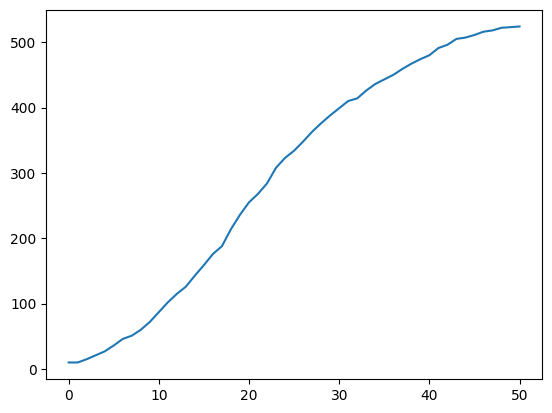

In [26]:
parameters = {
    "steps": 50,
    "n_agents": 1000,
    "infection_weight": 0.5,
}
model = Model(parameters=parameters)

results = model.run()

plt.plot(results.variables.Model.cumulative_infections)

In [27]:
model.pop_maker.eval_affiliations()



______________________________________
Number of agents per location
______________________________________

               n_agents                                                   
                  count       mean       std   min   25%   50%   75%   max
location_class                                                            
Friendship        514.0   1.935798  0.603565   0.0   2.0   2.0   2.0   3.0
Home              317.0   3.154574  1.610317   1.0   2.0   3.0   4.0   9.0
School              5.0  22.600000  5.366563  13.0  25.0  25.0  25.0  25.0
Work               41.0   9.926829  0.468521   7.0  10.0  10.0  10.0  10.0


______________________________________
Number of affiliated locations per agent
______________________________________

count    1000.000000
mean        2.515000
std         1.063441
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         6.000000
Name: n_affiliated_locations, dtype: float64


,0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95
95,0.002,0.004,0.001,0.005,0.009,0.013,0.014,0.011,0.016,0.014,0.007,0.004,0.009,0.019,0.008,0.009,0.014,0.021,0.018,0.016
90,0.003,0.000,0.002,0.008,0.013,0.016,0.013,0.016,0.017,0.014,0.014,0.011,0.005,0.016,0.008,0.010,0.013,0.023,0.020,0.018
85,0.009,0.005,0.000,0.007,0.018,0.030,0.032,0.021,0.032,0.021,0.029,0.021,0.015,0.030,0.013,0.019,0.030,0.044,0.023,0.021
80,0.003,0.004,0.005,0.009,0.024,0.020,0.020,0.015,0.020,0.023,0.018,0.015,0.007,0.023,0.015,0.022,0.032,0.030,0.013,0.014
75,0.001,0.001,0.003,0.017,0.023,0.028,0.014,0.015,0.023,0.016,0.018,0.018,0.009,0.034,0.040,0.024,0.022,0.019,0.010,0.009
70,0.007,0.004,0.003,0.004,0.020,0.023,0.013,0.015,0.024,0.022,0.023,0.021,0.021,0.020,0.034,0.040,0.015,0.013,0.008,0.008
65,0.007,0.003,0.008,0.018,0.030,0.033,0.031,0.035,0.033,0.020,0.035,0.037,0.028,0.090,0.020,0.034,0.023,0.030,0.016,0.019
60,0.004,0.009,0.009,0.003,0.019,0.022,0.018,0.024,0.021,0.024,0.026,0.020,0.016,0.028,0.021,0.009,0.007,0.015,0.005,0.009
55,0.002,0.005,0.008,0.012,0.024,0.031,0.037,0.023,0.029,0.024,0.043,0.044,0.020,0.037,0.021,0.018,0.015,0.021,0.011,0.004
50,0.011,0.004,0.006,0.014,0.032,0.030,0.025,0.035,0.035,0.038,0.058,0.043,0.026,0.035,0.023,0.018,0.018,0.029,0.014,0.007


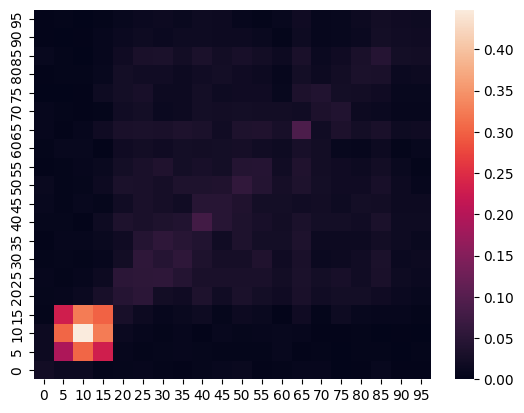

In [28]:
import popy.utils as utils

for agent in model.agents:
    agent.age_5 = utils.group_it(agent.age, start=0, step=5, n_steps=20, return_value="lower_bound")

utils.create_contact_matrix(model.agents, attr="age_5", plot=True)